In [1]:
import numpy as np
import pandas as pd
import xlsxwriter
import os
import datetime
from scipy import stats
from sqlalchemy import create_engine
from datetime import date, timedelta
import pymysql
import psycopg2
import warnings
import time
warnings.filterwarnings("ignore")
n = 1
Today = date.today().strftime("%Y-%m-%d")
os.chdir('C:\\Apply\\add github\\hasti')

In [5]:
connection = pymysql.connect(host='172.31.6.6',
user='weeda',
password='K=6kDW?d[&9V]=#nw-)Kzvida',
port= 3306,
cursorclass=pymysql.cursors.DictCursor)
cur = connection.cursor()
cur.execute("""
               SELECT * from profiling.daily_district
    WHERE created_date = '2024-01-01';""")
               
df = pd.DataFrame(cur.fetchall(), columns = [x[0] for x in cur.description])

In [7]:
filename = 'C:\\Apply\\add github\\hasti\\df.xlsx'

# Save the DataFrame to an Excel file
df.to_excel(filename, index=False)  # Set index=False if you don't want to write row indices


In [8]:
# Define a list of columns that we are interested in for analysis
cols = ['count_requested_rides', 'count_finished_rides', 'f_rate', 'count_cancelled_rides', 
        'count_active_driver', 'avg_distance', 'avg_time_create_accept', 'sum_price', 'avg_price', 
        'sum_commission', 'sum_subsidy', 'sum_voucher', 'sum_incentive', 'sum_driver_regular_earning', 
        'sum_driver_fraud_earning']

# Convert average distance from meters to kilometers
df['avg_distance'] = df['avg_distance'] / 1000

# Scale monetary values from raw units to millions for easier interpretation
df['sum_price'] = df['sum_price'] / 10000000
df['avg_price'] = df['avg_price'] / 10000000
df['sum_incentive'] = df['sum_incentive'] / 10000000
df['sum_commission'] = df['sum_commission'] / 10000000
df['sum_subsidy'] = df['sum_subsidy'] / 10000000
df['sum_voucher'] = df['sum_voucher'] / 10000000
df['sum_driver_regular_earning'] = df['sum_driver_regular_earning'] / 10000000
df['sum_driver_fraud_earning'] = df['sum_driver_fraud_earning'] / 10000000

# Fill any missing values in the DataFrame with 0 to avoid errors in calculations
df = df.fillna(0)

# Display the first few rows of the DataFrame to verify the changes
df.head()


,id,city_id,district_id,count_requested_rides,count_finished_rides,f_rate,count_cancelled_rides,count_active_driver,avg_distance,avg_time_create_accept,sum_price,avg_price,sum_commission,sum_subsidy,sum_voucher,sum_incentive,sum_driver_regular_earning,sum_driver_fraud_earning,created_date
0,1,1,579,25288,14761,0.583716,5919,9549,11.082,45.012127,938.4135,0.063574,137.622550,0.0,1.0195,47.9336,848.724550,-88.669450,2024-01-01
1,2,1,580,45915,27078,0.589742,10426,16488,10.289,45.834330,1840.9785,0.067988,269.750835,0.0,0.9985,120.7766,1692.004265,-147.975736,2024-01-01
2,3,1,581,23182,13187,0.568847,5601,10029,9.978,47.538333,921.4320,0.069874,135.650450,0.0,0.9305,31.3540,817.135550,-103.365950,2024-01-01
3,4,1,582,43943,25651,0.583733,10404,17673,11.125,43.154263,1854.6910,0.072305,271.979029,0.0,25.3065,112.4230,1695.134971,-134.249529,2024-01-01
4,5,1,583,20943,12090,0.577281,4966,9338,11.004,43.855749,891.0130,0.073698,130.220350,0.0,1.1050,30.0844,790.877050,-99.030950,2024-01-01


In [9]:
# Import necessary libraries
import numpy as np
import pandas as pd
from scipy import stats
from scipy.io import loadmat

# Filter the DataFrame to include only rows with finished rides and specific columns of interest
df_mg = pd.DataFrame(df[df['count_finished_rides'] > 0][cols], columns=cols)

# Store the column names in a list
columns = cols

# Identify features that approximately follow a normal distribution based on the Shapiro-Wilk test
# Features with a p-value >= 0.01 are not significantly different from normal
features = [c for c in columns if stats.shapiro(df_mg[c]).pvalue >= 0.01] 

# Apply log transformation to columns to normalize distributions, adding 1 to avoid log(0)
# Append transformed columns to the features list
for c in cols:
    df_mg[c] = np.log(df_mg[c]+1)
    features.append(c)

# Initialize a column to track outliers
df_mg['outlier'] = 0

# Mark rows as outliers if they are beyond 2 standard deviations from the mean
for f in features:
    df_mg['outlier'] += ((df_mg[f] > df_mg[f].mean()+2*df_mg[f].std()) | (df_mg[f] < df_mg[f].mean() - 2*df_mg[f].std())).astype(int)

# Filter the DataFrame to exclude outliers for the training set
df_train = df_mg[df_mg['outlier'] == 0]

# Define a multivariate normal distribution using the mean and standard deviation of the training features
dist = stats.multivariate_normal(df_train[features].mean().to_numpy(), df_train[features].std().to_numpy())

# Calculate probability density values for the features in df_mg based on the defined distribution
proba = dist.pdf(df_mg[features].to_numpy())


# Plotting Active Drivers vs. Average Distance

In this code, we visualize the relationship between the number of active drivers (`count_active_driver`) and the average distance (`avg_distance`). We also highlight outliers in the dataset. 

1. **Importing Libraries**: 
   - We import `matplotlib.pyplot` for plotting and `seaborn` for enhanced visual aesthetics.

2. **Setting Style**: 
   - The style of the plots is set to `whitegrid` using `seaborn`, which adds a grid to the background for better readability.

3. **Creating the Figure and Axes**:
   - A figure and axes are created with a specified size of 10x6 inches.

4. **Scatter Plot**:
   - We create a scatter plot with `count_active_driver` on the x-axis and `avg_distance` on the y-axis.

5. **Labeling Axes**:
   - The x-axis and y-axis are labeled accordingly for clarity.

6. **Highlighting Outliers**:
   - A second scatter plot is created to specifically highlight outliers (where `outlier` is greater than 1) in red. The size of these points is increased to `50` for better visibility.

7. **Adding Legend**:
   - A legend is added to distinguish the outlier points from the regular data points.

8. **Adding Title**:
   - A title is added to the plot to summarize its content.

9. **Displaying the Plot**:
   - Finally, `plt.show()` is called to display the plot.


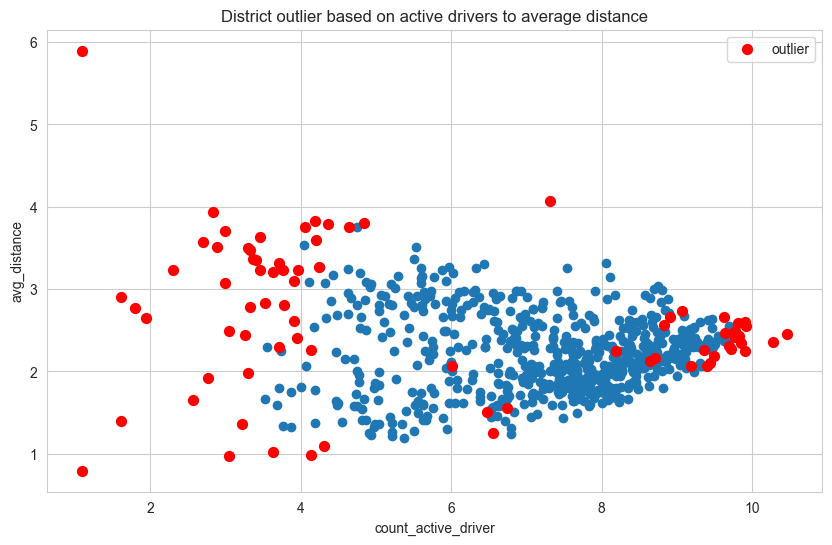

In [13]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots to white grid
sns.set_style("whitegrid")

# Create a figure and a set of subplots with a custom figure size
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot of active drivers vs average distance
ax.scatter(df_mg['count_active_driver'], df_mg['avg_distance'])
ax.set_xlabel('count_active_driver')  # Label for the x-axis
ax.set_ylabel('avg_distance')  # Label for the y-axis

# Highlight outliers in the plot
# Outliers are marked in red, with a larger size and labeled for clarity
ax.scatter(df_mg[df_mg['outlier'] > 1]['count_active_driver'], df_mg[df_mg['outlier'] > 1]['avg_distance'], c='r', s=50, label='outlier')
ax.legend()  # Display legend to identify the red points as outliers

# Add a title to the plot to describe the data being visualized
ax.set_title("District outlier based on active drivers to average distance")

# Display the plot
plt.show()


In [30]:
df_mg[df_mg['outlier'] > 1]

,count_requested_rides,count_finished_rides,f_rate,count_cancelled_rides,count_active_driver,avg_distance,avg_time_create_accept,sum_price,avg_price,sum_commission,sum_subsidy,sum_voucher,sum_incentive,sum_driver_regular_earning,sum_driver_fraud_earning,outlier
3,10.690671,10.152377,0.459785,9.250042,9.779850,2.495269,3.787689,7.526012,0.069810,5.609395,0.000000,3.269816,4.731124,7.436107,NaN,2
9,11.632520,11.121777,0.470032,10.134401,10.464559,2.457193,3.833926,8.337565,0.059932,6.420522,0.000000,1.689893,5.830034,8.269744,NaN,5
12,10.947872,10.419301,0.463381,9.453051,9.857758,2.341998,3.874882,7.508703,0.052986,5.592899,0.000000,1.178809,4.748954,7.421056,NaN,2
13,10.995528,10.496068,0.474277,9.527193,9.795178,2.440519,3.884362,7.526971,0.050050,5.610781,0.000000,1.148037,4.886548,7.448105,NaN,2
16,11.259413,10.655870,0.436230,9.807087,9.905186,2.246861,3.944491,7.982359,0.066712,6.048215,0.000000,1.381709,6.217906,8.008741,4.410092,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714,4.317488,0.693147,0.013423,3.610918,1.609438,1.399457,2.772589,0.022739,0.022739,0.004589,0.002996,0.000000,0.000000,0.018233,-0.001601,7
715,6.603944,4.510860,0.115217,5.513429,3.218876,1.356608,3.364994,1.123955,0.022816,0.345998,0.154436,0.000000,0.000000,0.979679,-0.282894,2
717,5.641907,4.844187,0.370459,4.584967,4.836282,3.803435,2.904817,3.101713,0.155755,1.634833,1.136229,0.000000,0.000000,2.896321,NaN,2
721,5.736572,4.127134,0.180162,4.762174,4.204693,3.590826,3.350192,2.321799,0.140389,1.025683,0.593879,0.000000,0.000000,2.128827,-3.816713,4


and for this code :

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots to a white grid background
sns.set_style("whitegrid")

# Create a figure and a single subplot with a specific size
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot of active drivers against sum of driver fraud earnings
ax.scatter(df_mg['count_active_driver'], df_mg['sum_driver_fraud_earning'])
ax.set_xlabel('count_active_driver')  # Label for the x-axis
ax.set_ylabel('sum_driver_fraud_earning')  # Label for the y-axis

# Highlight outliers in the data
# Outliers are shown in red, sized at 50 for better visibility, and labeled as 'outlier'
ax.scatter(df_mg[df_mg['outlier'] > 1]['count_active_driver'], df_mg[df_mg['outlier'] > 1]['sum_driver_fraud_earning'], c='r', s=50, label='outlier')
ax.legend()  # Show a legend to identify what the red points represent

# Title the plot to indicate what it's showing
ax.set_title("District outlier based on active drivers to sum_driver_fraud_earning")

# Display the plot
plt.show()

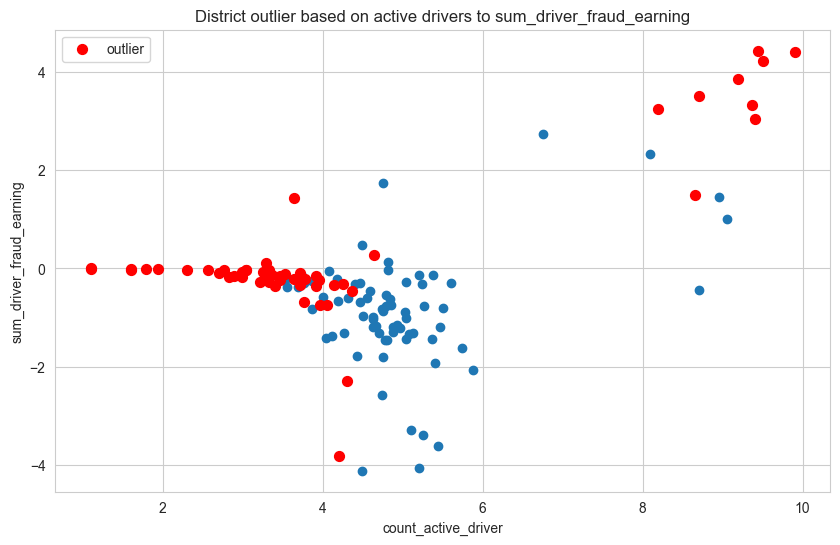

In [15]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots to a white grid background
sns.set_style("whitegrid")

# Create a figure and a single subplot with a specific size
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot of active drivers against sum of driver fraud earnings
ax.scatter(df_mg['count_active_driver'], df_mg['sum_driver_fraud_earning'])
ax.set_xlabel('count_active_driver')  # Label for the x-axis
ax.set_ylabel('sum_driver_fraud_earning')  # Label for the y-axis

# Highlight outliers in the data
# Outliers are shown in red, sized at 50 for better visibility, and labeled as 'outlier'
ax.scatter(df_mg[df_mg['outlier'] > 1]['count_active_driver'], df_mg[df_mg['outlier'] > 1]['sum_driver_fraud_earning'], c='r', s=50, label='outlier')
ax.legend()  # Show a legend to identify what the red points represent

# Title the plot to indicate what it's showing
ax.set_title("District outlier based on active drivers to sum_driver_fraud_earning")

# Display the plot
plt.show()


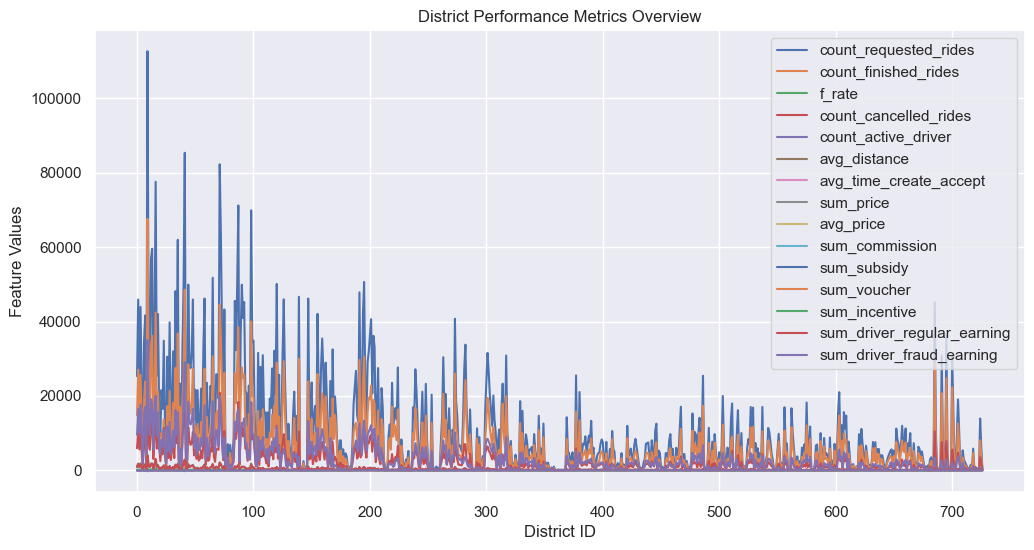

In [32]:
# Import the necessary libraries for plotting
import matplotlib.pyplot as plt
# This magic command ensures that matplotlib graphs will be embedded into the notebook
%matplotlib inline
import seaborn as sns

# Apply the default seaborn theme, scaling, and color palette
sns.set()

# Filter and create a DataFrame with only rows that have finished rides, and use specific columns
df_x = pd.DataFrame(df[df['count_finished_rides'] > 0][cols], columns=cols)

# Plot the DataFrame. Here, each numeric column is plotted as a line graph by default
# figsize specifies the size of the figure in width and height in inches
ax = df_x.plot(figsize=(12, 6))

# Set the x-axis label to 'District ID' to denote the different districts
ax.set_xlabel('District ID')

# Set the y-axis label to 'Feature Values' to indicate that the y-axis shows different metric values for each district
ax.set_ylabel('Feature Values')

# Add a title to the plot for additional clarity and context
ax.set_title('District Performance Metrics Overview')

# This line is optional here as %matplotlib inline will display plots automatically
plt.show()


In [31]:
df_x.head()

,count_requested_rides,count_finished_rides,f_rate,count_cancelled_rides,count_active_driver,avg_distance,avg_time_create_accept,sum_price,avg_price,sum_commission,sum_subsidy,sum_voucher,sum_incentive,sum_driver_regular_earning,sum_driver_fraud_earning
0,25288,14761,0.583716,5919,9549,11.082,45.012127,938.4135,0.063574,137.622550,0.0,1.0195,47.9336,848.724550,-88.669450
1,45915,27078,0.589742,10426,16488,10.289,45.834330,1840.9785,0.067988,269.750835,0.0,0.9985,120.7766,1692.004265,-147.975736
2,23182,13187,0.568847,5601,10029,9.978,47.538333,921.4320,0.069874,135.650450,0.0,0.9305,31.3540,817.135550,-103.365950
3,43943,25651,0.583733,10404,17673,11.125,43.154263,1854.6910,0.072305,271.979029,0.0,25.3065,112.4230,1695.134971,-134.249529
4,20943,12090,0.577281,4966,9338,11.004,43.855749,891.0130,0.073698,130.220350,0.0,1.1050,30.0844,790.877050,-99.030950


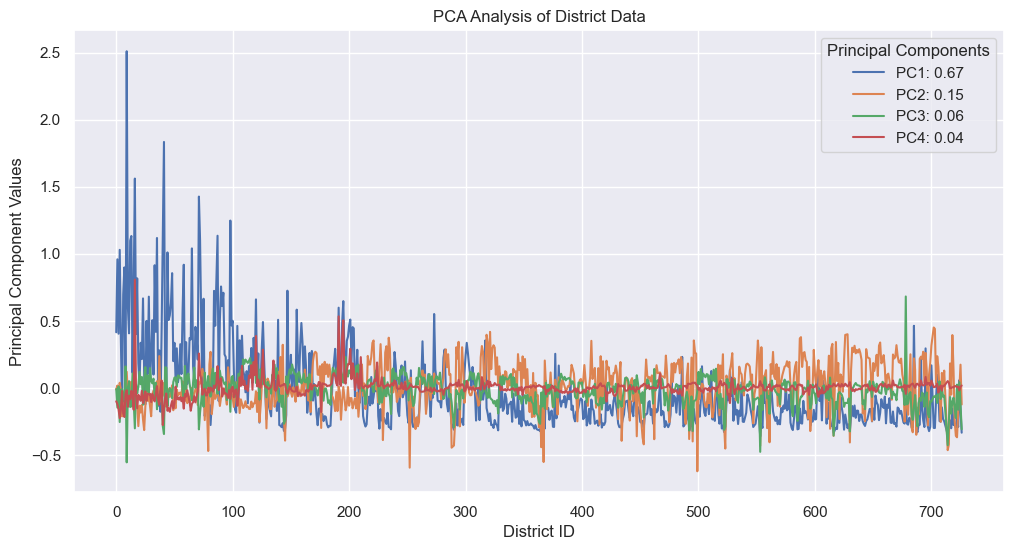

In [34]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the index for an 80% train-test split
split_index = int(0.8 * len(df))

# Normalize the data within the range [0, 1] for each feature to ensure equal weighting in the PCA
dfs_pca = df_x.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Split the normalized data into training and testing sets
x_train = dfs_pca.iloc[:split_index]
x_test = dfs_pca.iloc[split_index:]

# Initialize PCA with 4 components to reduce dimensionality and set a random state for reproducibility
pca = PCA(n_components=4, random_state=0)

# Fit PCA on the training data and transform both training and test data
x_train_pca = pd.DataFrame(pca.fit_transform(x_train), index=x_train.index)
x_test_pca = pd.DataFrame(pca.transform(x_test), index=x_test.index)

# Combine the transformed training and testing data for visualization
df_pca = pd.concat([x_train_pca, x_test_pca])

# Plot the principal components
fig, ax = plt.subplots(figsize=(12, 6))
for i in range(4):
    ax.plot(df_pca.index, df_pca[i], label=f'PC{i+1}: {pca.explained_variance_ratio_[i]:.2f}')

ax.set_xlabel('District ID')  # Assuming 'District ID' is represented by the DataFrame's index
ax.set_ylabel('Principal Component Values')
ax.set_title('PCA Analysis of District Data')
ax.legend(title="Principal Components")

# Display the plot
plt.show()


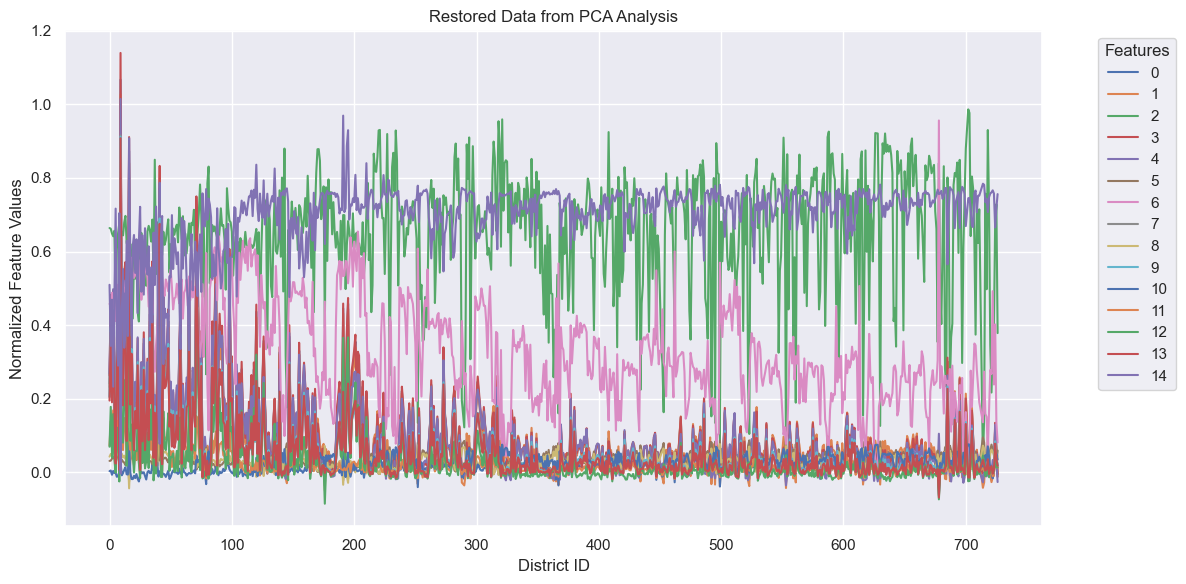

In [43]:
import matplotlib.pyplot as plt

# Restore the original data from the PCA transformed data
#df_restored = pd.DataFrame(pca.inverse_transform(df_pca), columns=cols, index=df_pca.index)
df_restored = pd.DataFrame(pca.inverse_transform(df_pca), index=df_pca.index)


# Plot the restored data using a line plot
fig, ax = plt.subplots(figsize=(12, 6))
df_restored.plot(ax=ax)

# Setting labels and title for the plot
ax.set_xlabel('District ID')  # or another appropriate label depending on the data
ax.set_ylabel('Normalized Feature Values')
ax.set_title('Restored Data from PCA Analysis')

# Enhancing the legend to not overlap the data
ax.legend(title="Features", bbox_to_anchor=(1.05, 1), loc='upper left')

# Optionally, display the plot
plt.tight_layout()
plt.show()


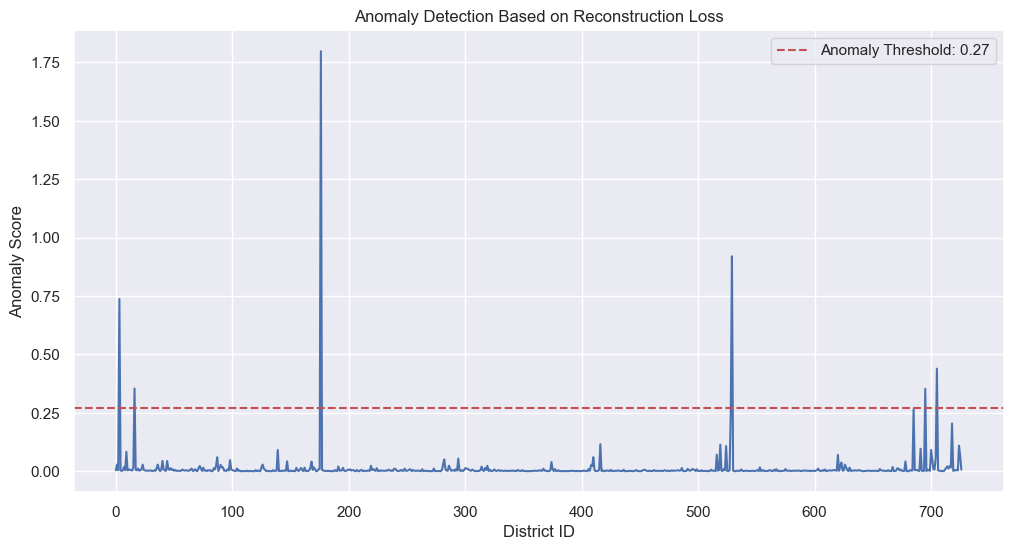

In [44]:
# Import the numpy library for numerical operations
import numpy as np
import pandas as pd  # Pandas for handling dataframes

# Define a function to calculate anomaly scores based on reconstruction loss
def get_anomaly_scores(df_original, df_restored):
    # Calculate the squared reconstruction error (loss) for each data point
    loss = np.sum((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
    # Convert the numpy array of losses to a pandas Series for easier handling and plotting
    loss = pd.Series(data=loss, index=df_original.index)
    # Return the Series of losses (anomaly scores)
    return loss

# Compute anomaly scores using the defined function
scores = get_anomaly_scores(dfs_pca, df_restored)

# Plot the anomaly scores to identify potential outliers
# figsize specifies the dimensions of the plot in inches
# Plot the anomaly scores with added labels and title
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the anomaly scores
scores.plot(ax=ax)

# Add labels and title to the plot
ax.set_xlabel('District ID')  # X-axis represents the district or index (assuming district ID)
ax.set_ylabel('Anomaly Score')  # Y-axis represents the calculated anomaly score
ax.set_title('Anomaly Detection Based on Reconstruction Loss')  # Title describes what the plot represents

# Optionally add a horizontal line to mark a threshold for anomalies (example: score > threshold is an anomaly)
threshold = scores.mean() + 3 * scores.std()  # Example threshold: 3 standard deviations above the mean
ax.axhline(y=threshold, color='r', linestyle='--', label=f'Anomaly Threshold: {threshold:.2f}')

# Add a legend
ax.legend()

# Display the plot
plt.show()


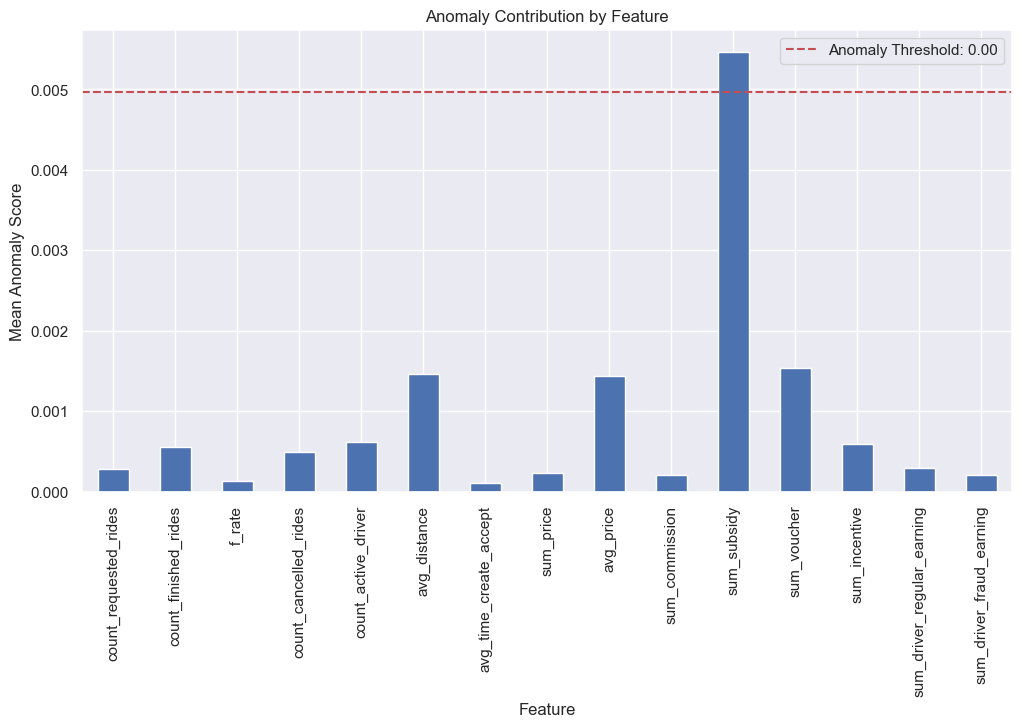

In [45]:
# Define a function to calculate anomaly scores for each feature (column) individually
def get_feature_anomaly_scores(df_original, df_restored):
    # Calculate the squared reconstruction error for each feature
    feature_loss = (np.array(df_original) - np.array(df_restored)) ** 2
    # Convert the numpy array of feature losses to a DataFrame with the same columns as the original data
    feature_loss_df = pd.DataFrame(data=feature_loss, index=df_original.index, columns=df_original.columns)
    # Return the DataFrame of losses (anomaly scores per feature)
    return feature_loss_df

# Compute anomaly scores per feature using the defined function
feature_scores = get_feature_anomaly_scores(dfs_pca, df_restored)

# Summarize anomaly scores per feature (columns)
# Calculate the mean anomaly score for each feature
mean_feature_scores = feature_scores.mean()

# Plot the feature-level anomaly scores for interpretation
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the mean anomaly score per feature
mean_feature_scores.plot(kind='bar', ax=ax)

# Add labels and title to the plot
ax.set_xlabel('Feature')  # X-axis represents the features (columns) of the dataset
ax.set_ylabel('Mean Anomaly Score')  # Y-axis represents the mean anomaly score per feature
ax.set_title('Anomaly Contribution by Feature')  # Title describes what the plot represents

# Optionally, add a horizontal line to mark a threshold for high anomaly features
threshold = mean_feature_scores.mean() + 3 * mean_feature_scores.std()  # Example threshold
ax.axhline(y=threshold, color='r', linestyle='--', label=f'Anomaly Threshold: {threshold:.2f}')

# Add a legend
ax.legend()

# Display the plot
plt.show()


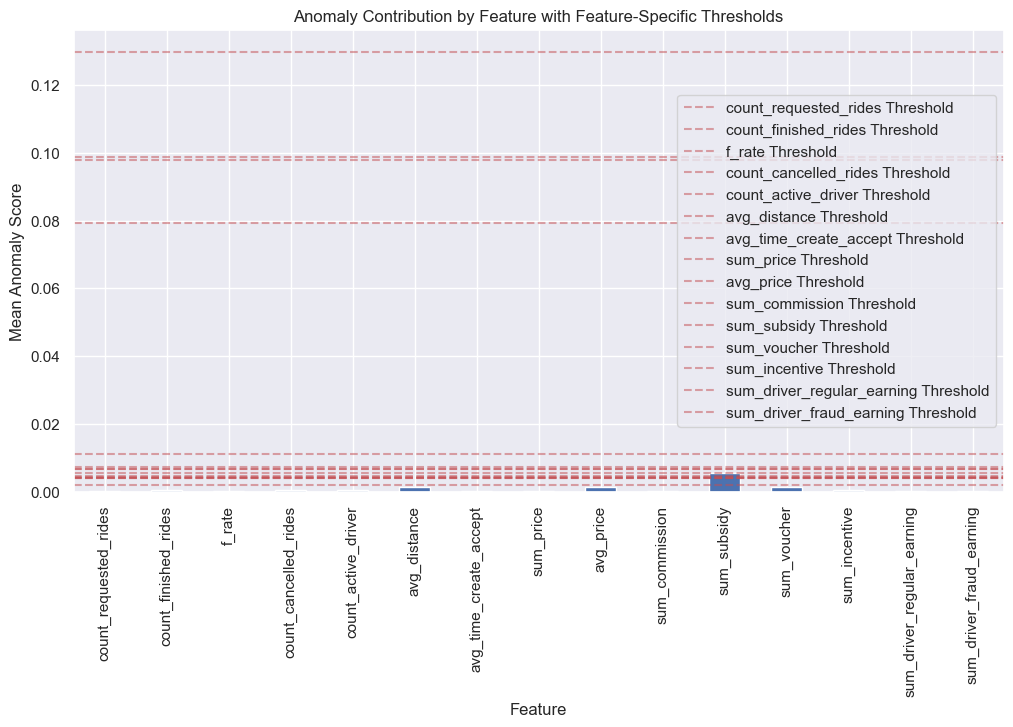

In [46]:
# Set feature-specific thresholds (e.g., 3 standard deviations above the mean for each feature)
thresholds = feature_scores.mean() + 3 * feature_scores.std()

# Plot the feature-level anomaly scores with feature-specific thresholds
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the mean anomaly score per feature
mean_feature_scores.plot(kind='bar', ax=ax)

# Add feature-specific threshold lines for each feature
for i, feature in enumerate(mean_feature_scores.index):
    ax.axhline(y=thresholds[feature], color='r', linestyle='--', alpha=0.5, label=f'{feature} Threshold')

# Add labels and title
ax.set_xlabel('Feature')
ax.set_ylabel('Mean Anomaly Score')
ax.set_title('Anomaly Contribution by Feature with Feature-Specific Thresholds')

# Add legend
ax.legend()

plt.show()


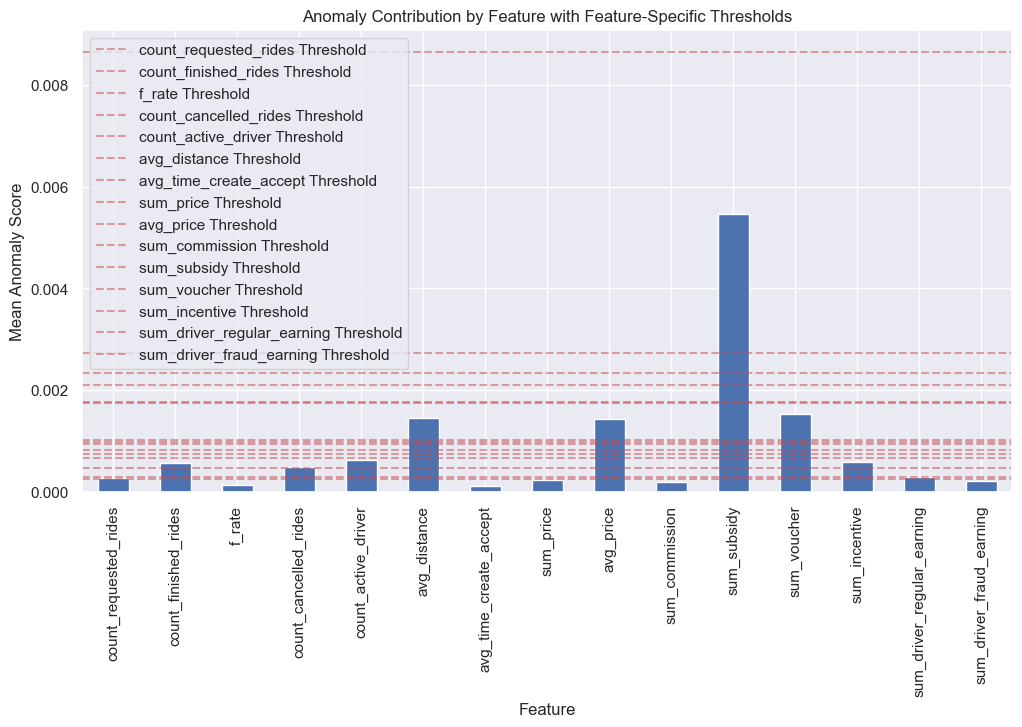

In [47]:
# Set feature-specific thresholds based on the 95th percentile of each feature's anomaly scores
thresholds = feature_scores.apply(lambda x: np.percentile(x, 95))

# Plot the feature-level anomaly scores with feature-specific thresholds
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the mean anomaly score per feature
mean_feature_scores.plot(kind='bar', ax=ax)

# Add feature-specific threshold lines for each feature
for i, feature in enumerate(mean_feature_scores.index):
    ax.axhline(y=thresholds[feature], color='r', linestyle='--', alpha=0.5, label=f'{feature} Threshold')

# Add labels and title
ax.set_xlabel('Feature')
ax.set_ylabel('Mean Anomaly Score')
ax.set_title('Anomaly Contribution by Feature with Feature-Specific Thresholds')

# Add legend
ax.legend()

plt.show()


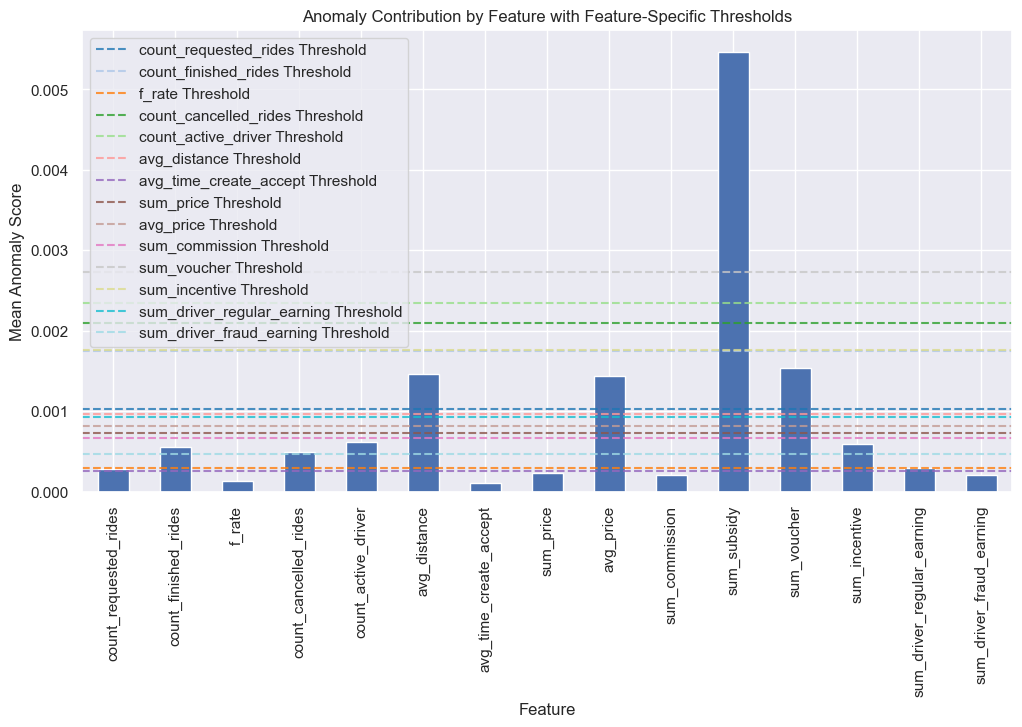

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Set feature-specific thresholds based on the 95th percentile of each feature's anomaly scores
thresholds = feature_scores.apply(lambda x: np.percentile(x, 95))

# Initialize a color map for different threshold lines
import matplotlib.cm as cm
colors = cm.get_cmap('tab20', len(mean_feature_scores))  # Get a colormap with enough distinct colors

# Plot the feature-level anomaly scores with feature-specific thresholds
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the mean anomaly score per feature
mean_feature_scores.plot(kind='bar', ax=ax)

# Add feature-specific threshold lines with different colors
for i, feature in enumerate(mean_feature_scores.index):
    threshold_value = thresholds[feature]
    if threshold_value < 0.008:  # Remove lines with high thresholds
        ax.axhline(y=threshold_value, color=colors(i), linestyle='--', alpha=0.8, label=f'{feature} Threshold')

# Add labels and title
ax.set_xlabel('Feature')
ax.set_ylabel('Mean Anomaly Score')
ax.set_title('Anomaly Contribution by Feature with Feature-Specific Thresholds')

# Add legend
ax.legend()

plt.show()


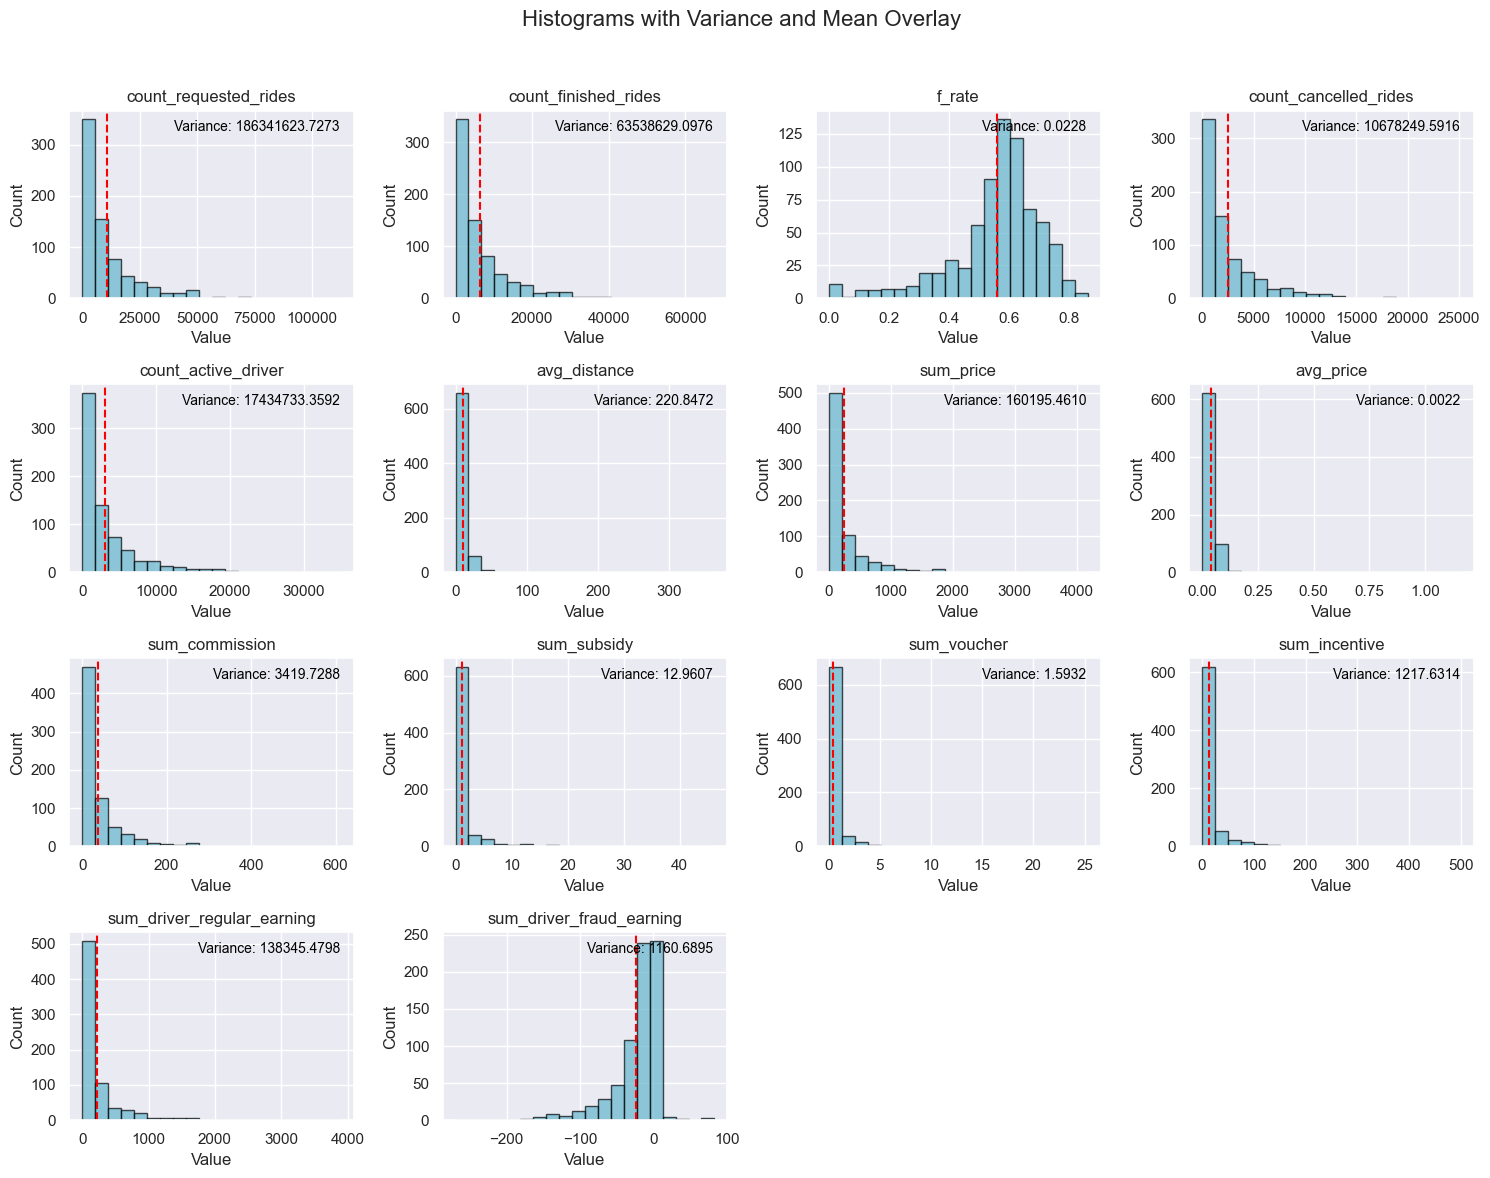

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your DataFrame is named 'df' and the unwanted columns have been removed

# Drop 'id', 'city_id', 'district_id' from the DataFrame if present
df_filtered = df.drop(columns=['id', 'city_id', 'district_id', 'avg_time_create_accept', 'created_date'], errors='ignore')

# Calculate the mean and variance for each feature
means = df_filtered.mean()
variances = df_filtered.var()

# Create a figure for histograms with variance overlays
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 12))
axs = axs.flatten()

# Loop through each column to plot the histogram and overlay the variance
for i, column in enumerate(df_filtered.columns):
    # Plot histogram
    axs[i].hist(df_filtered[column], bins=20, color='c', edgecolor='black', alpha=0.7)
    
    # Plot the mean line
    axs[i].axvline(means[column], color='red', linestyle='--', label='Mean')
    
    # Add text to indicate variance
    axs[i].text(0.95, 0.95, f'Variance: {variances[column]:.4f}', 
                verticalalignment='top', horizontalalignment='right',
                transform=axs[i].transAxes, color='black', fontsize=10)
    
    # Set titles and labels
    axs[i].set_title(f'{column}', fontsize=12)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Count')

# Remove extra subplots (if any)
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Add a main title and adjust layout
plt.suptitle('Histograms with Variance and Mean Overlay', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()


Is anomaly: False Loss: 1.57090296215934


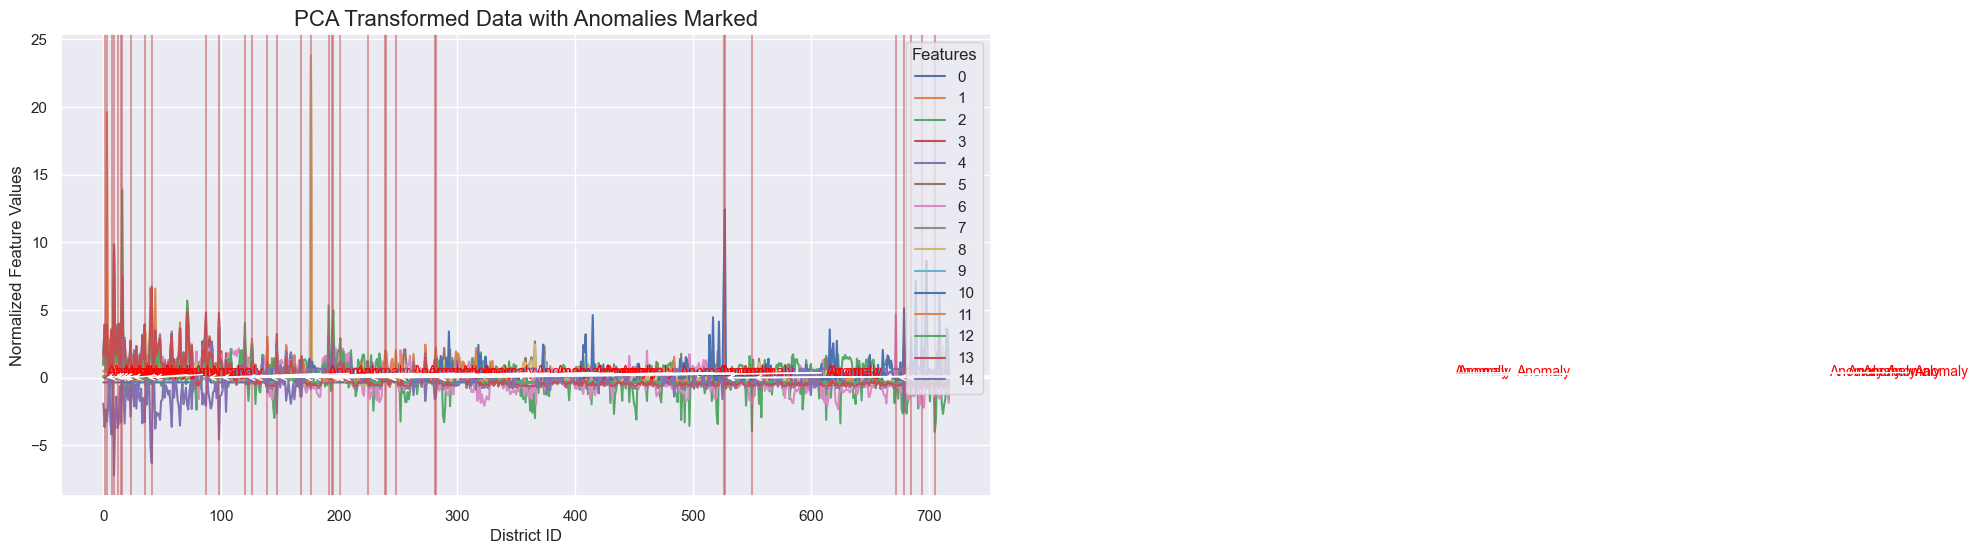

Detected anomalies at indices: [1, 3, 7, 9, 12, 15, 16, 23, 35, 41, 87, 98, 120, 126, 139, 147, 168, 176, 191, 194, 195, 201, 224, 239, 240, 248, 281, 282, 526, 527, 550, 672, 679, 685, 694, 705]


In [61]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Normalize the data using StandardScaler to reduce reconstruction error
scaler = StandardScaler()
df_x_scaled = scaler.fit_transform(df_x)

# Step 2: Apply PCA on the scaled data with more components (e.g., 6 components)
pca = PCA(n_components=6, random_state=0)
pca.fit(df_x_scaled)

# Step 3: Define the is_anomaly function (same as before)
def is_anomaly(data, pca, threshold):
    pca_data = pca.transform(data)
    restored_data = pca.inverse_transform(pca_data)
    loss = np.sum((data - restored_data) ** 2)
    return loss > threshold, loss

# Step 4: Calculate a dynamic threshold based on reconstruction errors
losses = []
for row in df_x_scaled:
    _, loss = is_anomaly([row], pca, threshold=0)  # Calculate loss for each row
    losses.append(loss)

# Use a threshold based on the 95th percentile of the reconstruction losses
threshold = np.percentile(losses, 95)

# Example: Check if a single data point is an anomaly using the calculated threshold
x = [df_x_scaled[2]]
is_anomaly_result = is_anomaly(x, pca, threshold)
print("Is anomaly:", is_anomaly_result[0], "Loss:", is_anomaly_result[1])

# Part 2: Plot the normalized data with marked anomalies

# Convert dfs_pca to a DataFrame (assuming dfs_pca represents normalized data)
dfs_pca = pd.DataFrame(df_x_scaled)

# Plot the normalized data
fig, ax = plt.subplots(figsize=(12, 6))
dfs_pca.plot(ax=ax)

# List to store the indices of detected anomalies
pca_index = []

# Loop through each row in the DataFrame and check for anomalies
for index, row in dfs_pca.iterrows():
    lo, loss = is_anomaly([row], pca, threshold)  # Use the dynamic threshold
    if lo:
        # Draw a vertical line at the index of the anomaly
        ax.axvline(row.name, color='r', linestyle='--', alpha=0.5)
        # Append the index of the anomaly to the list
        pca_index.append(index)

# Enhancing the visualization

# Set titles and labels, changing X-axis label to 'District ID'
ax.set_title('PCA Transformed Data with Anomalies Marked', fontsize=16)
ax.set_xlabel('District ID', fontsize=12)  # Updated to District ID
ax.set_ylabel('Normalized Feature Values', fontsize=12)

# Highlight detected anomalies in red
for i in pca_index:
    ax.annotate('Anomaly', xy=(i, 0), xycoords='data', xytext=(i, 1),
                textcoords='offset points', arrowprops=dict(facecolor='red', arrowstyle='->'),
                fontsize=10, color='red')

# Remove any extra dotted lines
for line in ax.lines:
    line.set_linestyle('-')  # Ensure solid lines for data, no dotted lines

# Add legend
plt.legend(title="Features", loc='upper right')

# Add a grid for clarity
plt.grid(True)

# Show the plot with anomalies marked
plt.show()

# Optionally, print detected anomaly indices
print("Detected anomalies at indices:", pca_index)


In [22]:
# GMM
# Data processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model
from sklearn.mixture import GaussianMixture

In [23]:
# Import necessary library for Gaussian Mixture Model
from sklearn.mixture import GaussianMixture
import numpy as np

# Create a copy of the PCA-transformed DataFrame to use in Gaussian Mixture Modeling
gmm_df = df_pca.copy()
X = gmm_df  # Define the dataset to be used in the GMM

# Initialize the Gaussian Mixture Model with 3 components, 5 initialization runs for robustness, and a fixed random state for reproducibility
gmm = GaussianMixture(n_components=3, n_init=5, random_state=42)

# Fit the model on the data and predict cluster assignments for each sample
y_gmm = gmm.fit_predict(X)

# Calculate the log likelihood of each sample under the model, which serves as an anomaly score
score = gmm.score_samples(X)

# Add the score as a new column in the DataFrame
gmm_df['score'] = score

# Determine the threshold for anomalies based on the 4th percentile of the scores
pct_threshold = np.percentile(score, 4)

# Print the calculated threshold to the console
print(f'The threshold of the score is {pct_threshold:.2f}')

# Label data points as anomalies (1) if their score is below the threshold, otherwise normal (0)
gmm_df['anomaly_gmm_pct'] = gmm_df['score'].apply(lambda x: 1 if x < pct_threshold else 0)


The threshold of the score is 0.01


array([ 582,  589,  602,  609,  613,  614,  622,  633,  634,  838,  839,
       1018, 1058, 1066, 1070, 1073,   63, 1186,  155,  158,  159, 1046,
        917,  923,  988,  872,  814, 1001,  825], dtype=int64)

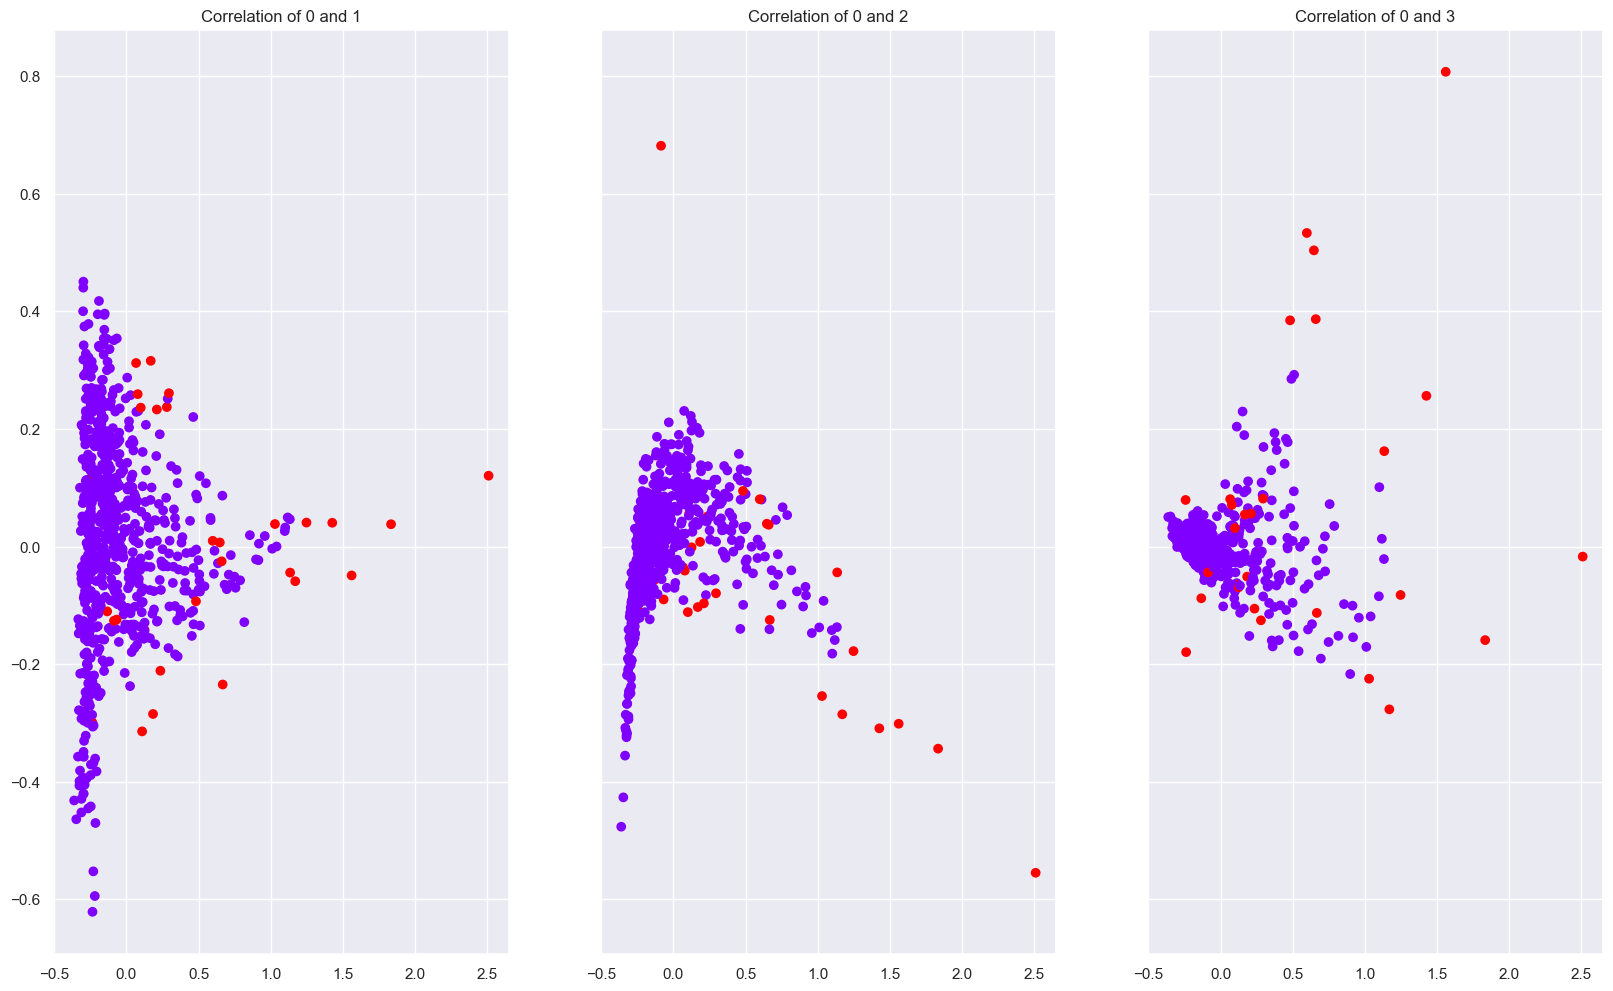

In [25]:
# Import the matplotlib library for creating visualizations
import matplotlib.pyplot as plt

# Create a figure and a set of subplots with 1 row and 3 columns, sharing the y-axis across subplots
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey=True, figsize=(20, 12))

# Visualize the correlation between the first two principal components
# ax0 is for plotting the first and second components
ax0.set_title('Correlation of 0 and 1')  # Title for the first subplot
ax0.scatter(gmm_df[0], gmm_df[1], c=gmm_df['anomaly_gmm_pct'], cmap='rainbow')  # Scatter plot colored by anomaly status

# Visualize the correlation between the first and third principal components
# ax1 is for plotting the first and third components
ax1.set_title('Correlation of 0 and 2')  # Title for the second subplot
ax1.scatter(gmm_df[0], gmm_df[2], c=gmm_df['anomaly_gmm_pct'], cmap='rainbow')  # Scatter plot colored by anomaly status

# Visualize the correlation between the first and fourth principal components
# ax2 is for plotting the first and fourth components
ax2.set_title('Correlation of 0 and 3')  # Title for the third subplot
ax2.scatter(gmm_df[0], gmm_df[3], c=gmm_df['anomaly_gmm_pct'], cmap='rainbow')  # Scatter plot colored by anomaly status

# Display the entire figure containing all subplots
plt.show()


The threshold of the score is 0.01


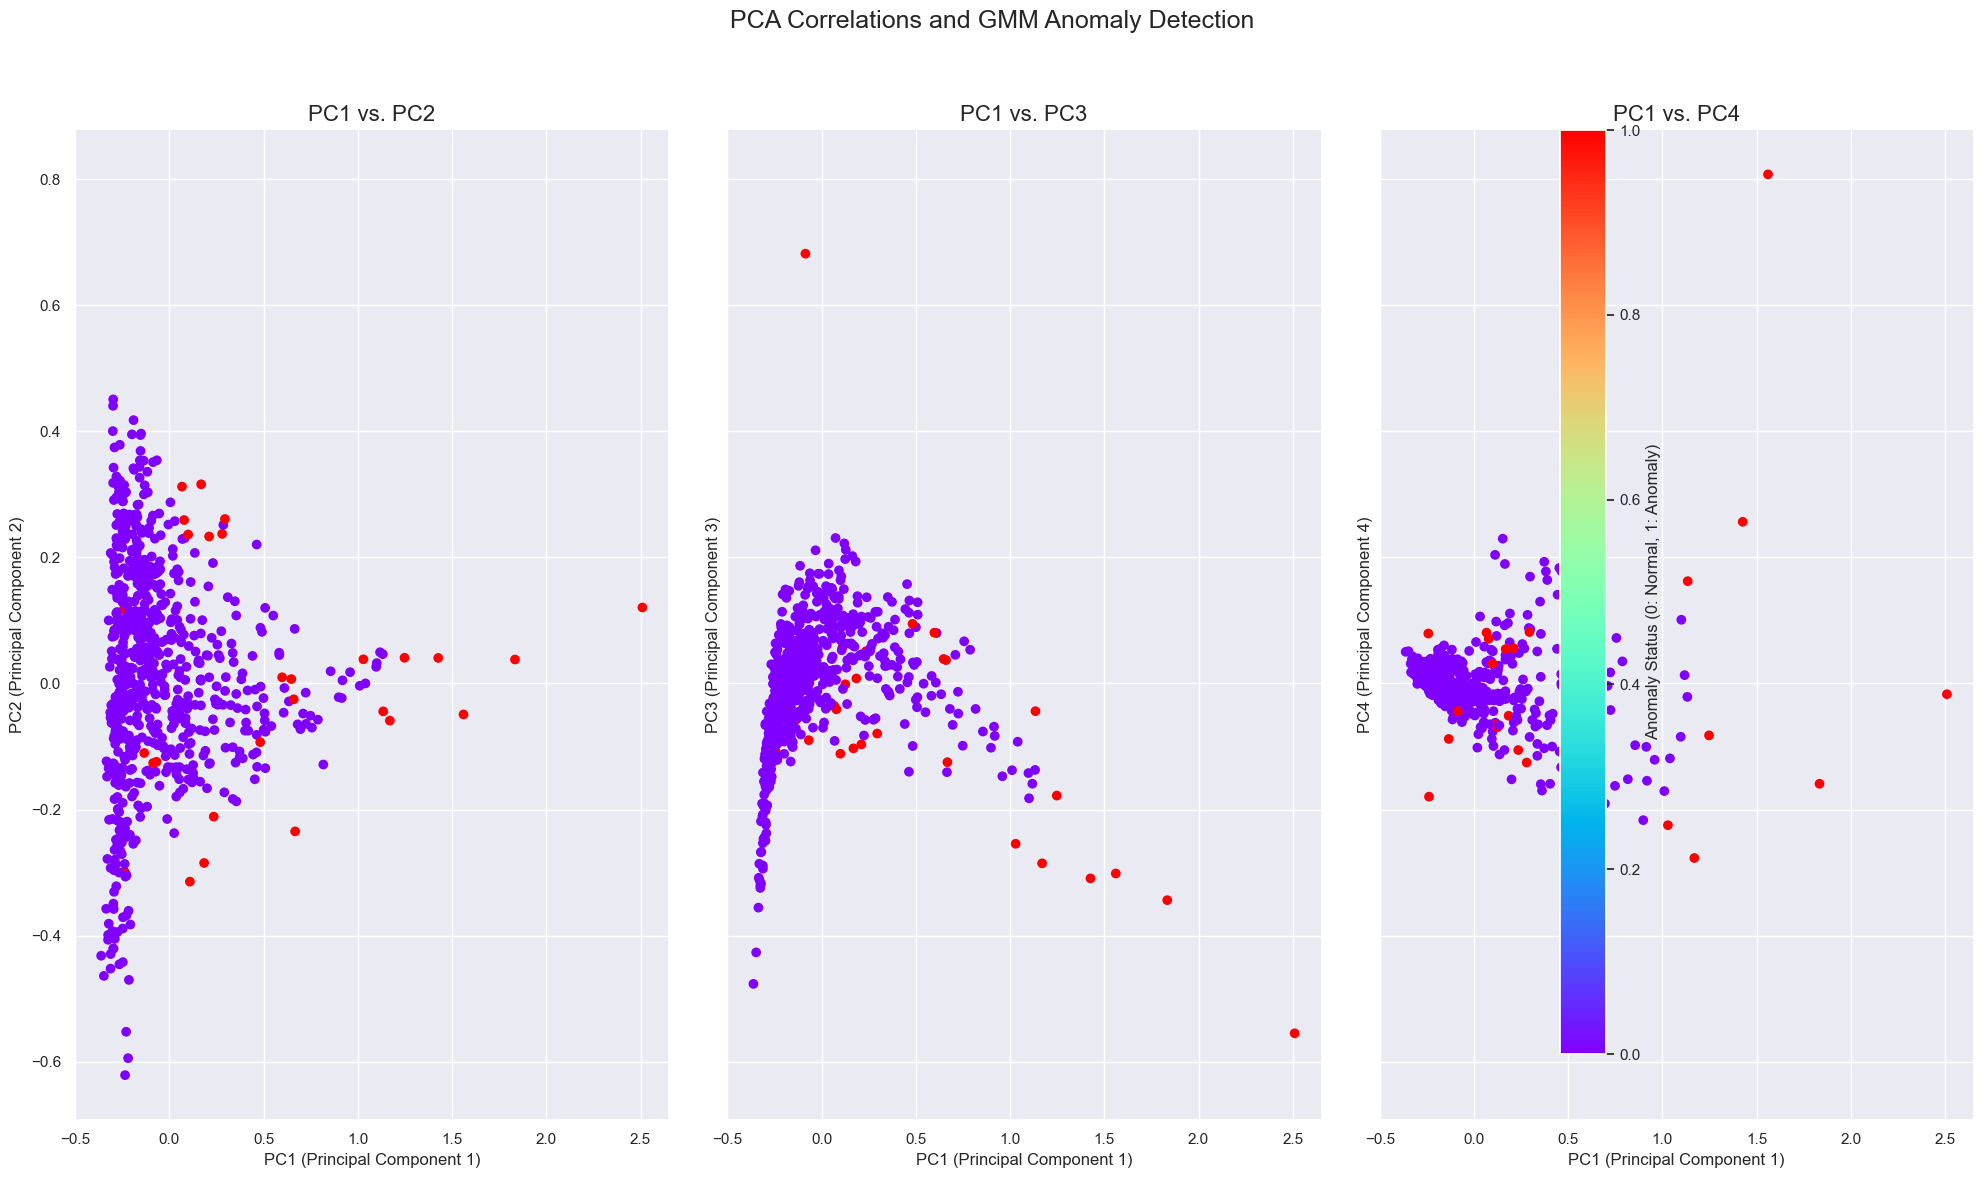

In [63]:
# Import the necessary library for Gaussian Mixture Model
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt

# Create a copy of the PCA-transformed DataFrame to use in Gaussian Mixture Modeling
gmm_df = df_pca.copy()
X = gmm_df  # Define the dataset to be used in the GMM

# Initialize the Gaussian Mixture Model with 3 components, 5 initialization runs for robustness, and a fixed random state for reproducibility
gmm = GaussianMixture(n_components=3, n_init=5, random_state=42)

# Fit the model on the data and predict cluster assignments for each sample
y_gmm = gmm.fit_predict(X)

# Calculate the log likelihood of each sample under the model, which serves as an anomaly score
score = gmm.score_samples(X)

# Add the score as a new column in the DataFrame
gmm_df['score'] = score

# Determine the threshold for anomalies based on the 4th percentile of the scores
pct_threshold = np.percentile(score, 4)

# Print the calculated threshold to the console
print(f'The threshold of the score is {pct_threshold:.2f}')

# Label data points as anomalies (1) if their score is below the threshold, otherwise normal (0)
gmm_df['anomaly_gmm_pct'] = gmm_df['score'].apply(lambda x: 1 if x < pct_threshold else 0)

# Create a figure and a set of subplots with 1 row and 3 columns, sharing the y-axis across subplots
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, sharey=True, figsize=(20, 12))

# Titles for the figure and subplots
fig.suptitle('PCA Correlations and GMM Anomaly Detection', fontsize=18)

# Add scatter plot for PC1 vs PC2 (Component 0 vs 1)
ax0.set_title('PC1 vs. PC2', fontsize=16)
scatter0 = ax0.scatter(gmm_df[0], gmm_df[1], c=gmm_df['anomaly_gmm_pct'], cmap='rainbow')
ax0.set_xlabel('PC1 (Principal Component 1)', fontsize=12)
ax0.set_ylabel('PC2 (Principal Component 2)', fontsize=12)

# Add scatter plot for PC1 vs PC3 (Component 0 vs 2)
ax1.set_title('PC1 vs. PC3', fontsize=16)
scatter1 = ax1.scatter(gmm_df[0], gmm_df[2], c=gmm_df['anomaly_gmm_pct'], cmap='rainbow')
ax1.set_xlabel('PC1 (Principal Component 1)', fontsize=12)
ax1.set_ylabel('PC3 (Principal Component 3)', fontsize=12)

# Add scatter plot for PC1 vs PC4 (Component 0 vs 3)
ax2.set_title('PC1 vs. PC4', fontsize=16)
scatter2 = ax2.scatter(gmm_df[0], gmm_df[3], c=gmm_df['anomaly_gmm_pct'], cmap='rainbow')
ax2.set_xlabel('PC1 (Principal Component 1)', fontsize=12)
ax2.set_ylabel('PC4 (Principal Component 4)', fontsize=12)

# Add a color bar to indicate the anomaly status (0 = normal, 1 = anomaly)
fig.colorbar(scatter2, ax=[ax0, ax1, ax2], orientation='vertical', label='Anomaly Status (0: Normal, 1: Anomaly)')

# Show the entire figure containing all subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout to fit the title
plt.show()


In [26]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline

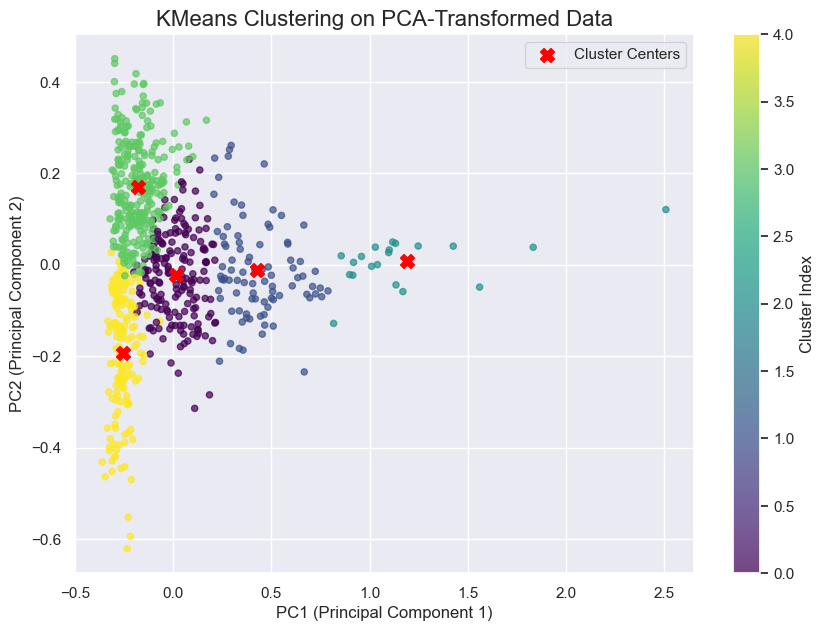

In [64]:
# Import necessary libraries for clustering and plotting
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Initialize the KMeans clustering model with 5 clusters and a fixed random state for reproducibility
kmeans = KMeans(n_clusters=5, random_state=0)

# Fit the KMeans model to the PCA-transformed DataFrame
kmeans.fit(df_pca)

# Predict the cluster indices for each data point in the PCA-transformed DataFrame
predicted_cluster_indexes = kmeans.predict(df_pca)

# Create a scatter plot to visualize the data points colored by their cluster assignment
plt.figure(figsize=(10, 7))
scatter = plt.scatter(df_pca[0], df_pca[1], c=predicted_cluster_indexes, s=20, alpha=0.7, cmap='viridis')

# Extract the cluster centers from the KMeans model
centers = kmeans.cluster_centers_

# Scatter plot for the cluster centers marked in red for easy distinction
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, label='Cluster Centers', marker='X')

# Enhancing the visualization

# Set title and axis labels
plt.title('KMeans Clustering on PCA-Transformed Data', fontsize=16)
plt.xlabel('PC1 (Principal Component 1)', fontsize=12)
plt.ylabel('PC2 (Principal Component 2)', fontsize=12)

# Add a color bar to indicate cluster assignments
color_bar = plt.colorbar(scatter)
color_bar.set_label('Cluster Index', fontsize=12)

# Add a legend for the cluster centers
plt.legend(loc='upper right')

# Show grid for better visualization
plt.grid(True)

# Display the plot
plt.show()


[ 1 -1  1 -1  1  1  1  1  1 -1  1  1 -1 -1  1  1 -1  1  1  1]
Number of outliers detected: 22
Number of normal samples detected: 705


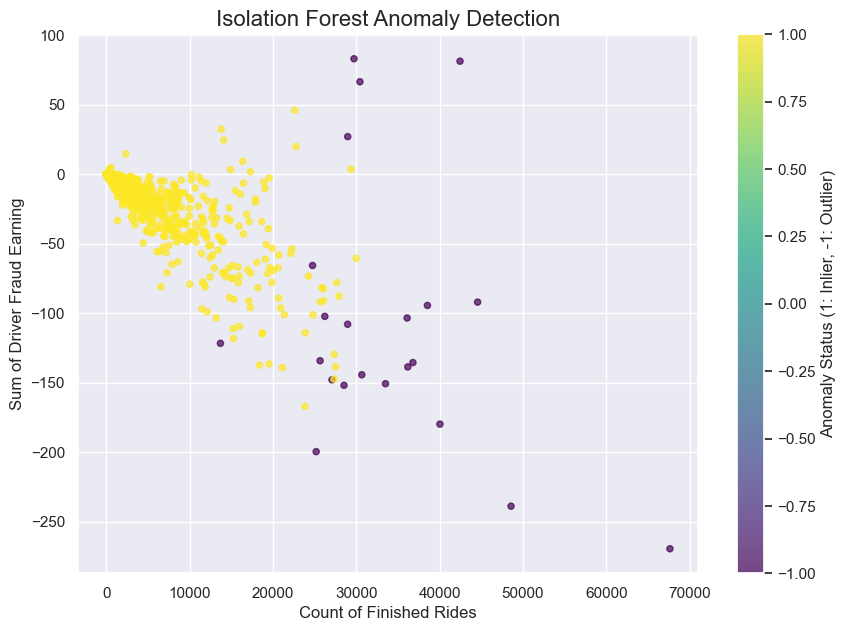

In [65]:
# Import necessary libraries for anomaly detection and plotting
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Initialize the Isolation Forest model
# Set the number of base estimators in the ensemble, the proportion of outliers in the data, and use all samples for training each tree
iforest = IsolationForest(n_estimators=100, contamination=0.03, max_samples='auto', random_state=42)

# Fit the Isolation Forest model and predict the anomaly status of each sample
# The fit_predict method returns -1 for outliers and 1 for inliers (normal points)
prediction = iforest.fit_predict(df[cols])

# Print the first 20 predictions to get a sense of the model's output
print(prediction[:20])

# Calculate and print the number of outliers detected
print(f"Number of outliers detected: {len(prediction[prediction == -1])}")

# Calculate and print the number of normal samples detected
print(f"Number of normal samples detected: {len(prediction[prediction == 1])}")

# Scatter plot for the anomaly detection results
plt.figure(figsize=(10, 7))

# Scatter plot of count_finished_rides vs sum_driver_fraud_earning colored by prediction (inliers/outliers)
scatter = plt.scatter(df['count_finished_rides'], df['sum_driver_fraud_earning'], 
                      c=prediction, s=20, alpha=0.7, cmap='viridis')

# Enhancing the visualization

# Set title and axis labels
plt.title('Isolation Forest Anomaly Detection', fontsize=16)
plt.xlabel('Count of Finished Rides', fontsize=12)
plt.ylabel('Sum of Driver Fraud Earning', fontsize=12)

# Add a color bar to indicate inliers (-1) vs outliers (1)
color_bar = plt.colorbar(scatter)
color_bar.set_label('Anomaly Status (1: Inlier, -1: Outlier)', fontsize=12)

# Add grid for better visualization
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
# Anomaly Detection in Districts

## Overview

This project focuses on detecting anomalies within districts using machine learning techniques. 
The project leverages various data science tools and libraries to identify outliers or unusual patterns in the dataset. 
The goal is to provide insights into anomalies that could indicate potential issues in the data.

## Table of Contents

- [Installation](#installation)
- [Usage](#usage)
- [Features](#features)
- [Dependencies](#dependencies)
- [Contributing](#contributing)
- [License](#license)
- [Contact](#contact)

## Installation

To run this project locally, you will need to clone this repository and install the necessary Python libraries. Make sure you have Python installed (preferably version 3.7 or higher).

### Clone the Repository

```bash
git clone https://github.com/your-username/anomaly-detection-districts.git
cd anomaly-detection-districts
